In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Running the code below so that IPython shows the entire result of the code I run. 
This becomes helpful to me while visualizing/analyzing high number of plots in the same output.

In [2]:

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
#import missingno as msno
from sklearn.metrics import mean_squared_error
import numpy as np  #linear algebra
import pandas as pd  #data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from IPython.display import display, HTML, display_html

from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
import optuna.trial
from mlxtend.regressor import StackingCVRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import cross_val_score, KFold , cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
import math
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor ,Pool  
from tqdm import tqdm 
import hyperopt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import gc

gc.enable()
#Configure the default output state to generate output in notebook cells when show()
#show() may be called multiple times in a single Jupyter notebook cell to display multiple objects. The objects are displayed in order.
from bokeh.io import output_notebook, show
from bokeh.models import (
    BasicTicker,
    ColorBar,
    ColumnDataSource,
    LinearColorMapper,
    PrintfTickFormatter,
)
from bokeh.plotting import figure
from bokeh.transform import transform


random_state = 55


Loading Train and Test data sets.

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
train = df_train
test = df_test
print('raw train data size:',train.shape)# should be 80 features+1 prediction 
print('raw test data size:',test.shape)
train.info()# check generally data type and headers 

raw train data size: (1460, 81)
raw test data size: (1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   ob

save ID vriable to use later on in submission 

In [4]:
Id = "Id"

submission_ID = test.loc[:, Id]

train.drop(Id, axis=1, inplace=True)
test.drop(Id, axis=1, inplace=True)

# For identification purposes
train.loc[:, "Train"] = 1
test.loc[:, "Train"] = 0

test["SalePrice"] = 0

stacked_DF = pd.concat([train, test], ignore_index=True)


# Target Variable Distribution - Univariate

visulize the sale price distrebution with raw data ad log transform as the variable has high skewness 

Skewness Co-efficient: 1.883
Skewness Co-efficient: 0.121


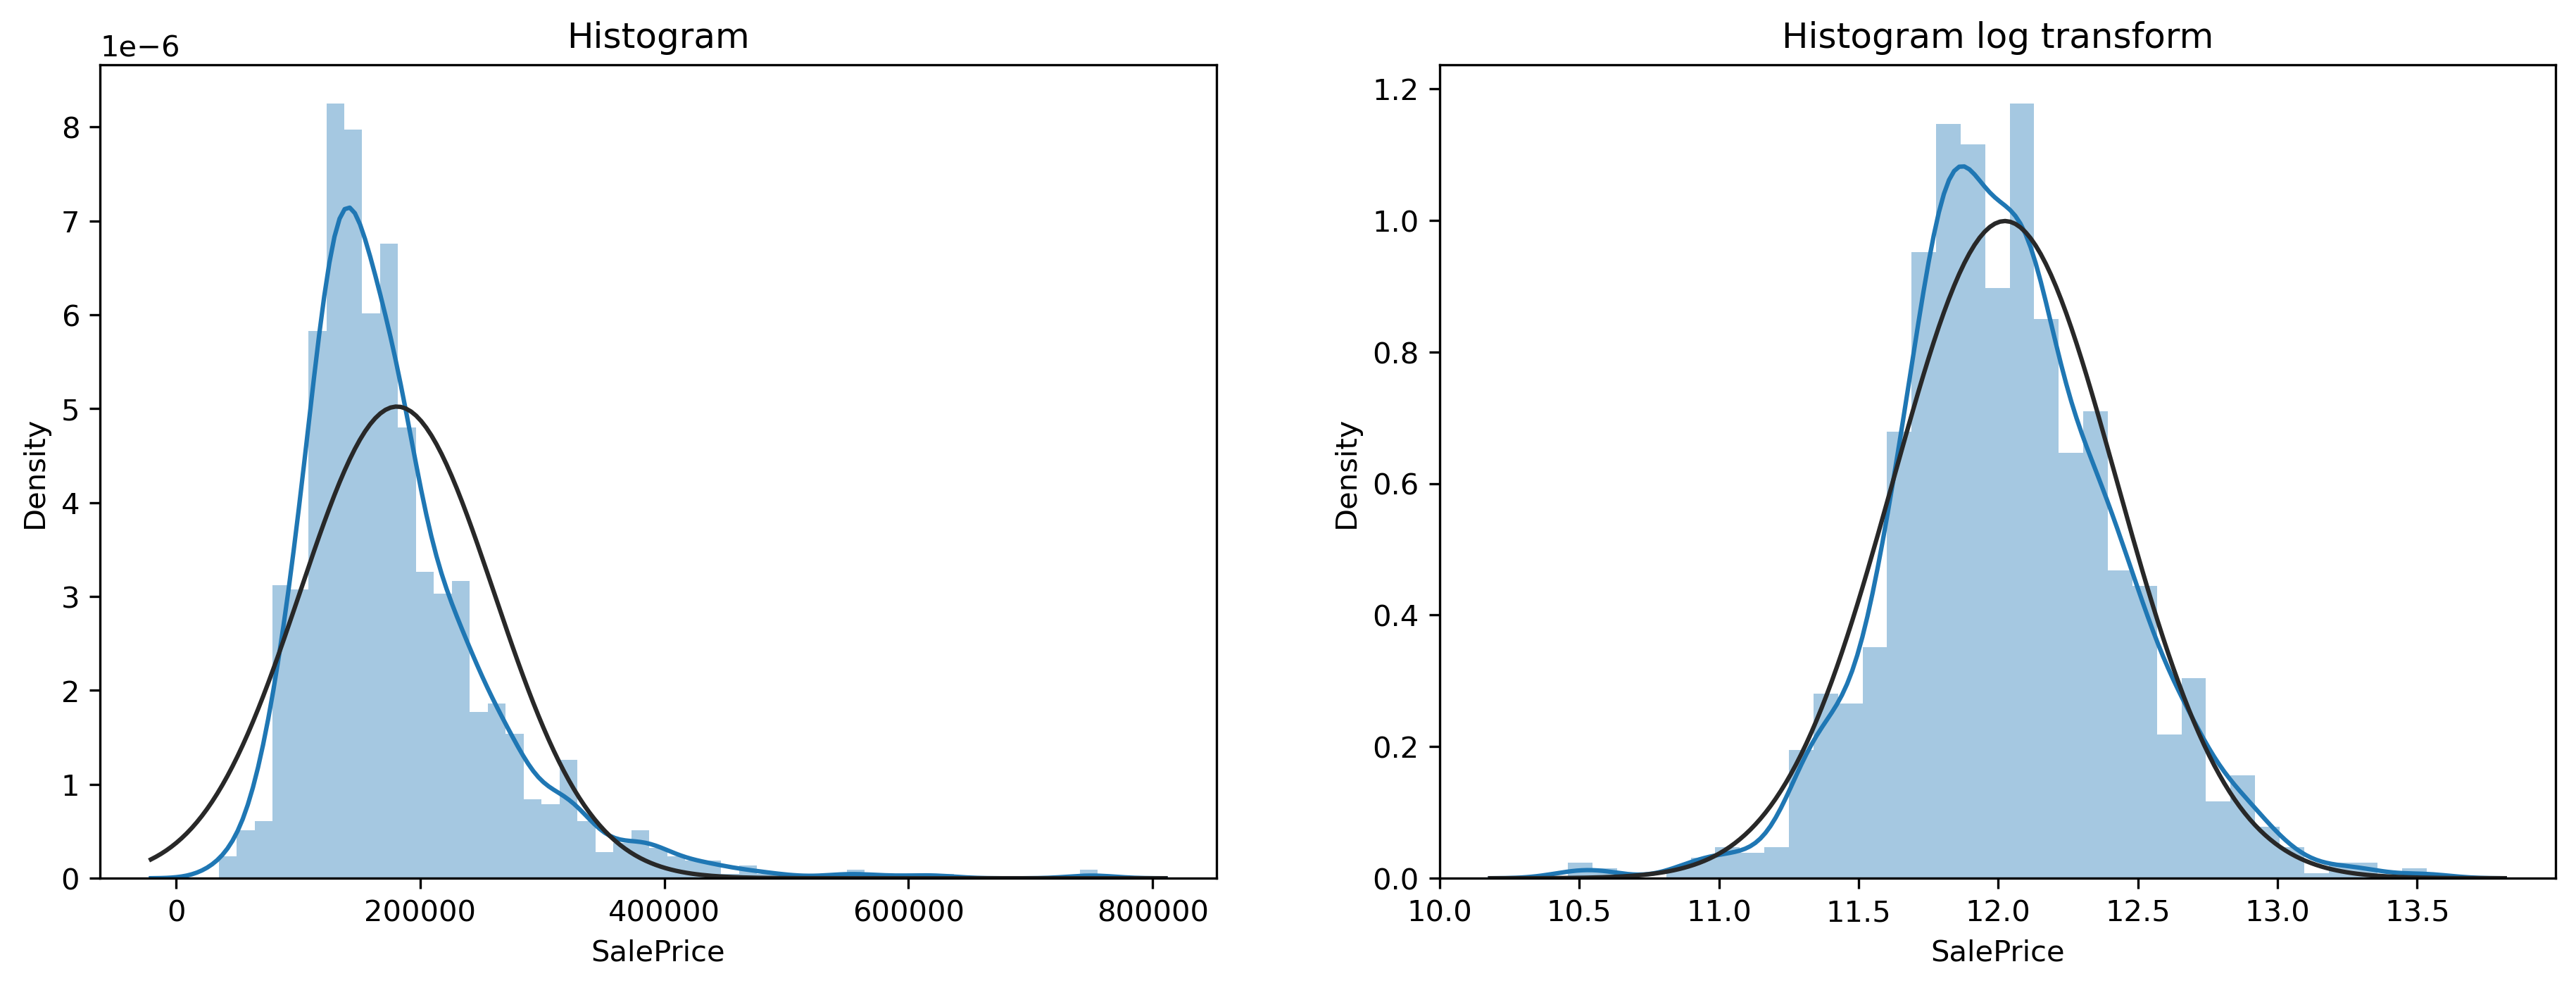

In [5]:
#calculate skewness 
plot_x = stacked_DF.loc[stacked_DF["Train"] == 1]["SalePrice"]
print(f"Skewness Co-efficient: {round(plot_x.skew(), 3)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

#generate the histograme 
from scipy import stats
sns.distplot(plot_x, fit=stats.norm, ax=ax1)
ax1.set_title('Histogram')



plot_x = stacked_DF.loc[stacked_DF["Train"] == 1]["SalePrice"]
target_transform = np.log1p(plot_x)
# calculate the skewness 
print(f"Skewness Co-efficient: {round(target_transform.skew(), 3)}")



#generate the histogram 
from scipy import stats
sns.distplot(target_transform, fit=stats.norm, ax=ax2)
ax2.set_title('Histogram log transform')

plt.show()

# Bivariate Analyis

in this part we are mainly looking for correlation, outliers and relations between the features and the target variables. best way is scatter plot for numirical variable and boxplot for categorical variable

/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


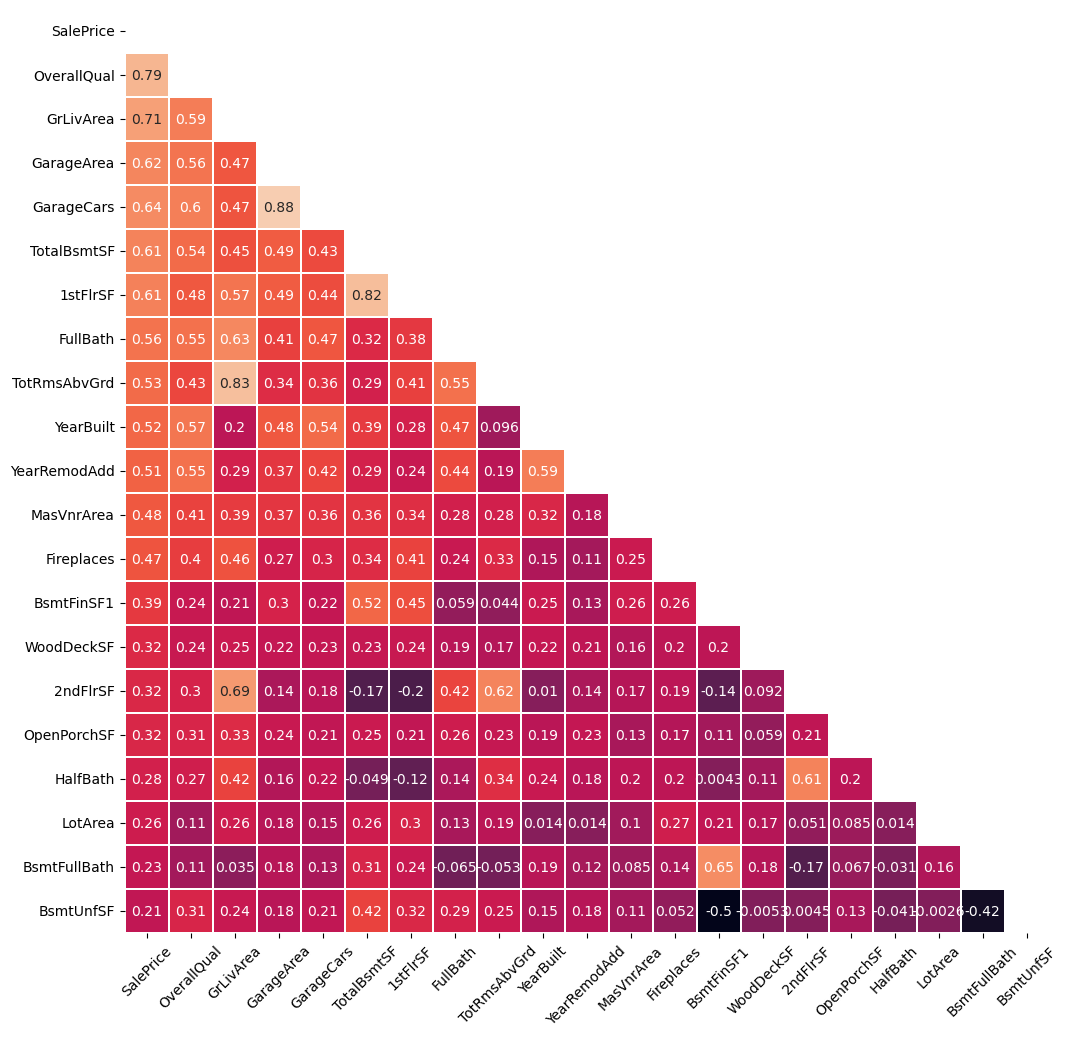

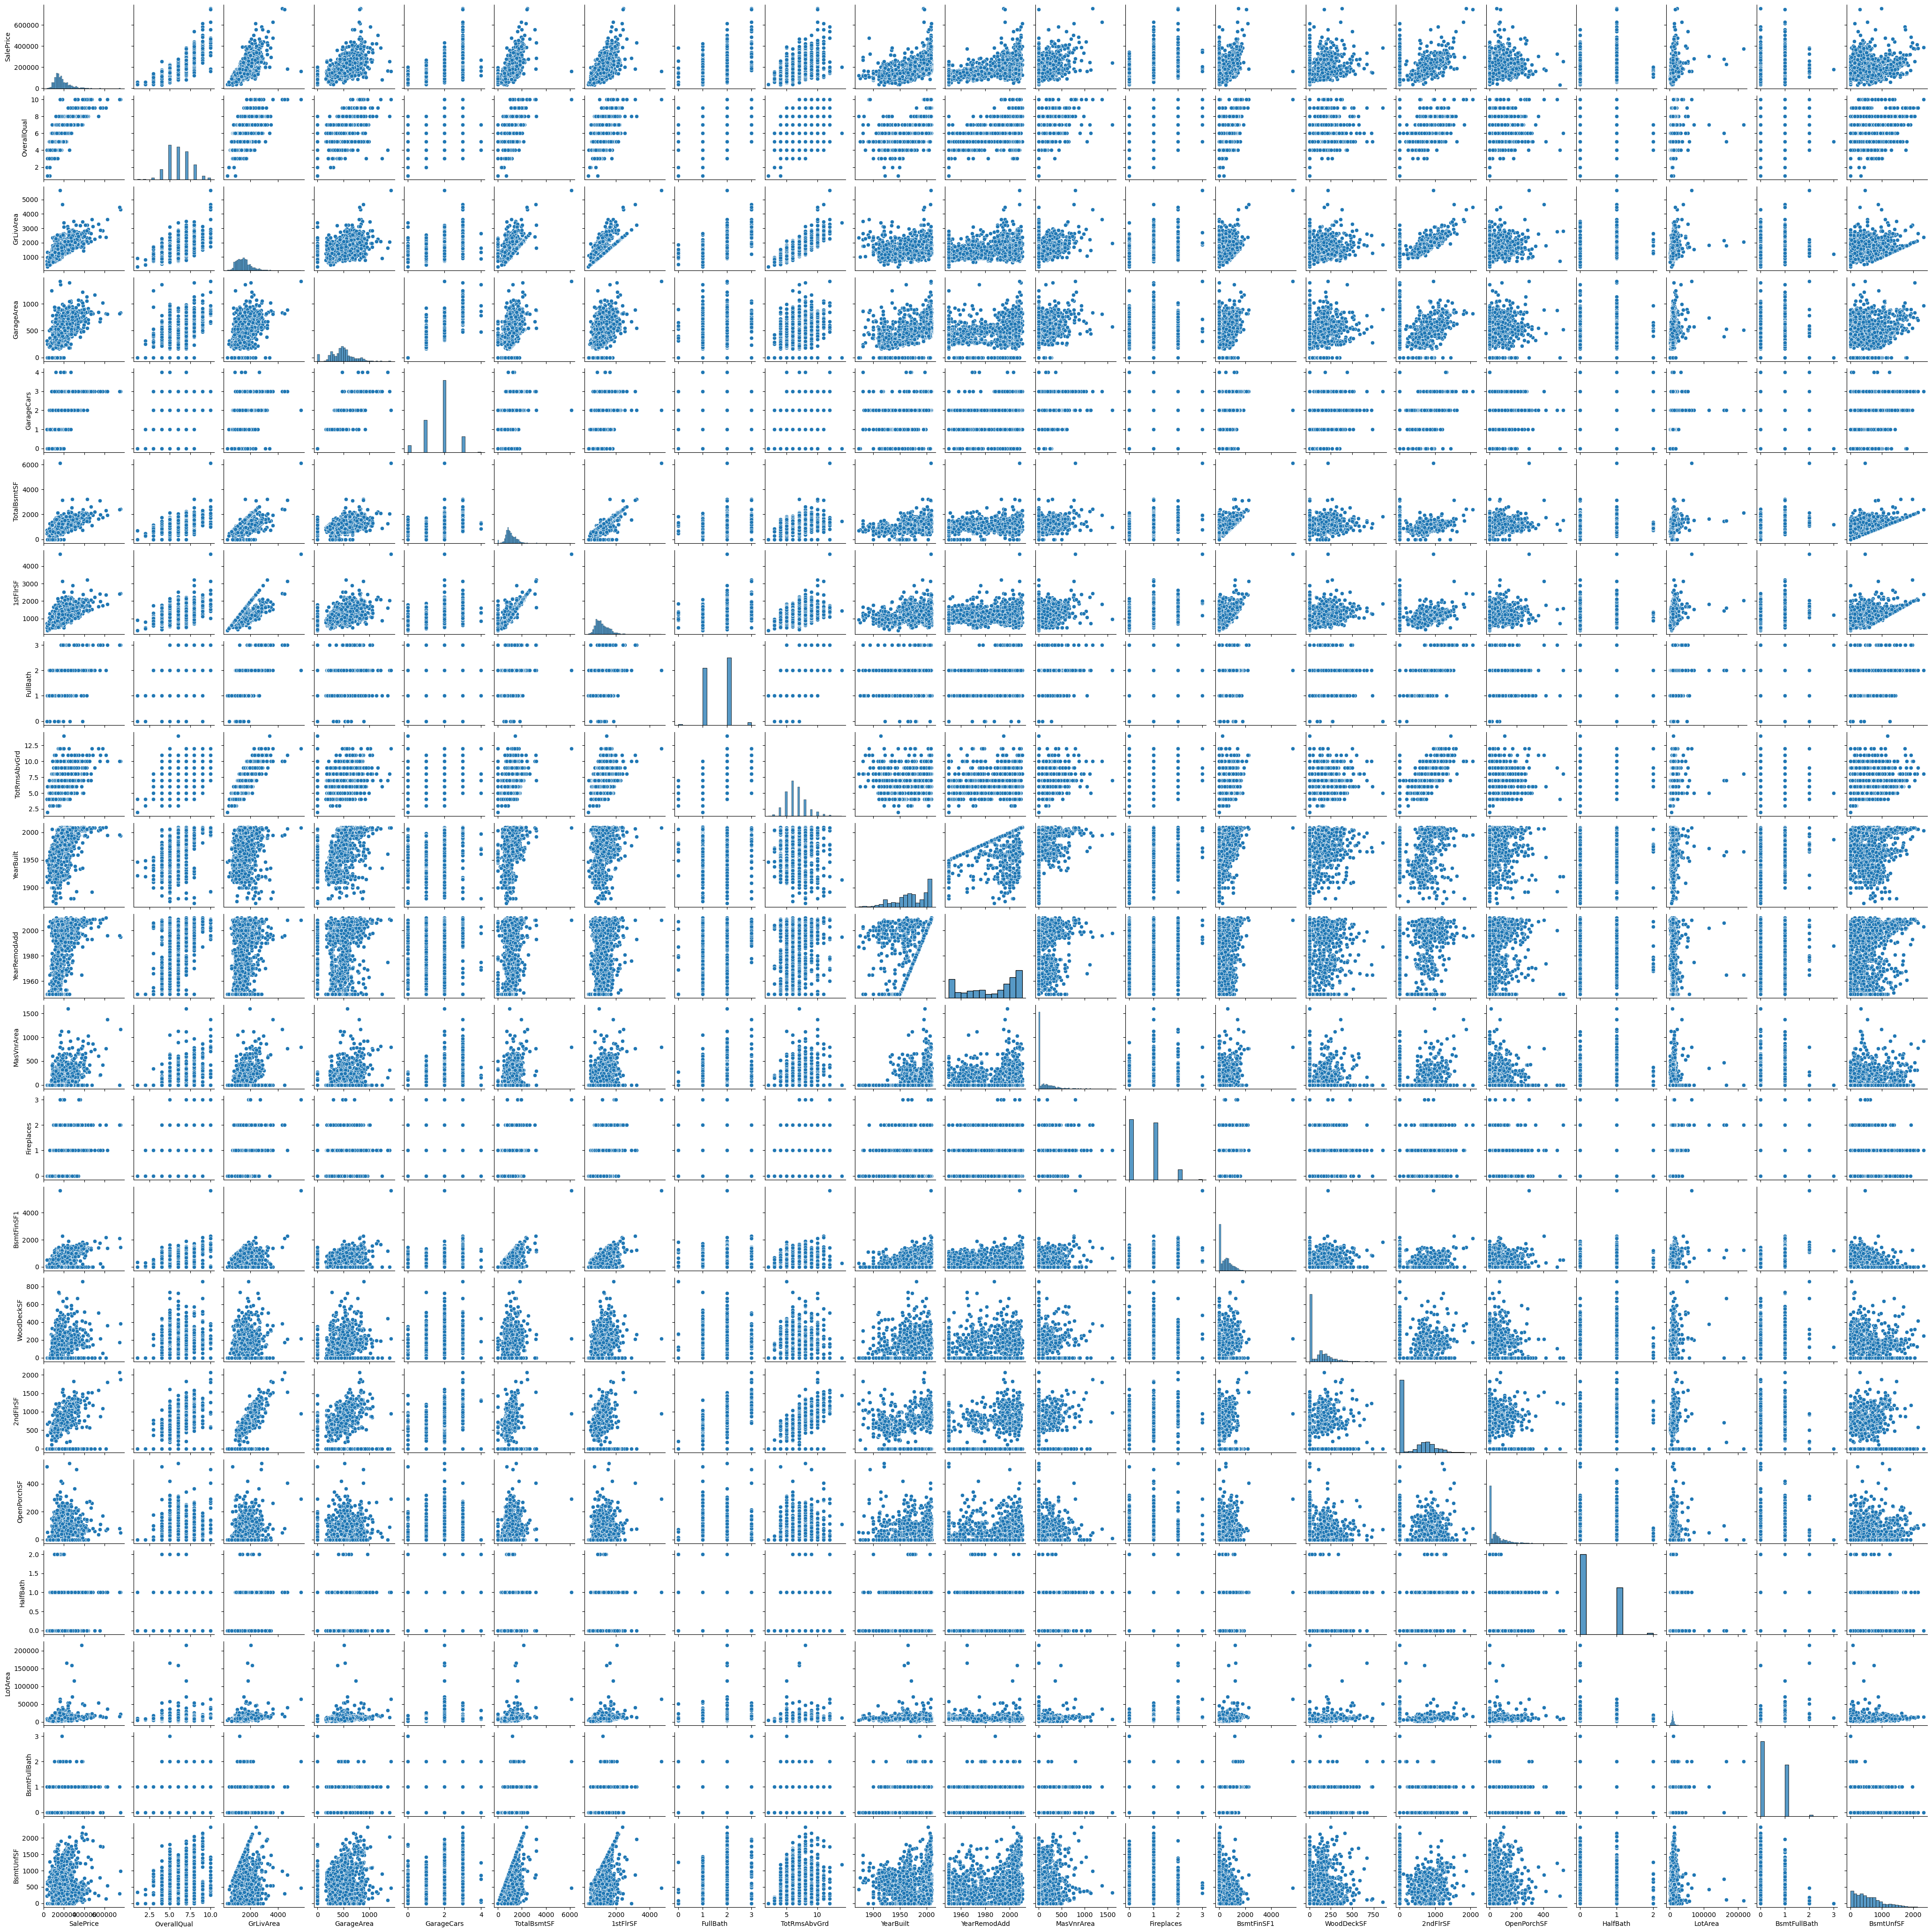

In [6]:
numeric_data = train[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 
                             'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1',
                            'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF']]

corr = numeric_data.corr()
plt.figure(figsize=(12, 12))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, vmax=1, square=True, annot=True, mask=mask, cbar=False, linewidths=0.1)
plt.xticks(rotation=45)
sns.pairplot(numeric_data, size=2)

**observing the figures we can conclude the following **

* overall qua, garage area, GrLivArea, YrBuilt, LotArea and a few others have linear-like relationship with the target variable.

Moving on with the categorical bivariate analysis.

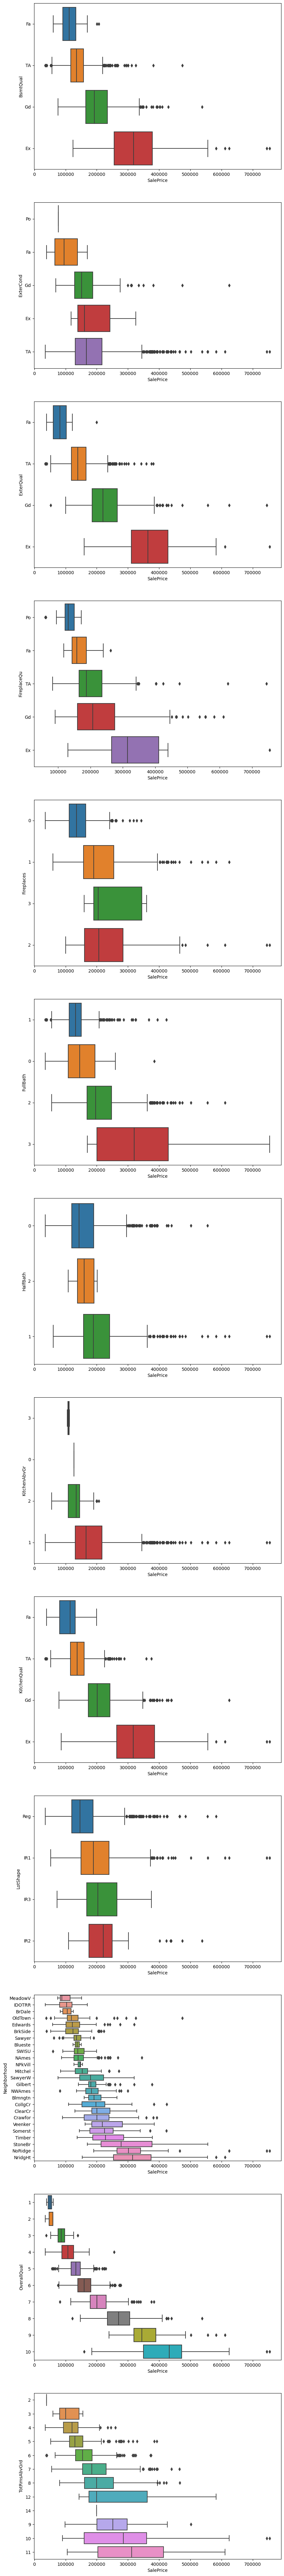

In [7]:
features_to_viz = [
        "KitchenQual",
    "LotShape",
    "OverallQual",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "KitchenAbvGr",
    "Neighborhood",
    "BsmtQual",
    "ExterQual",
    "FireplaceQu",
    "ExterCond",

]



features_to_viz = sorted(features_to_viz)

ncols = 1
nrows = math.ceil(len(features_to_viz) / ncols)
unused = nrows * ncols - len(features_to_viz)

(figw, figh) = (ncols * 10, nrows * 8)

(fig, ax) = plt.subplots(nrows, ncols, figsize=(figw, figh))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# ax = ax.flatten()
# for i in range(unused, 0, -1):
#     fig.delaxes(ax[-i])

for (n, col) in enumerate(features_to_viz):
    ordering = (
        stacked_DF.loc[stacked_DF["Train"] == 1]
        .groupby(by=col)["SalePrice"]
        .median()
        .sort_values()
        .index
    )
    sns.boxplot(
        x="SalePrice",
        y=col,
        data=stacked_DF.loc[stacked_DF["Train"] == 1],
        order=ordering,
        ax=ax[n],
        orient="h",
    )

plt.show()

from above we can conclude that OverallQual impacts SalePrice exponentially, Neighborhood matters. Features regarding quality also matter.The more irregular the lot shape is, the higher the Sale Price seems

# Missing Values

first identify the missing value then fill them with reasonable value 

In [8]:
print("Missing Value Counts in Train DF")
stacked_DF[stacked_DF["Train"] == 1].isna().sum()[
    stacked_DF[stacked_DF["Train"] == 1].isna().sum() > 0
].sort_values(ascending=False)

Missing Value Counts in Train DF


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [9]:
print("Missing Values in Test DF")
stacked_DF[stacked_DF["Train"] == 0].isna().sum()[
    stacked_DF[stacked_DF["Train"] == 0].isna().sum() > 0
].sort_values(ascending=False)


Missing Values in Test DF


PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
KitchenQual        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

In [10]:
nan = pd.DataFrame(stacked_DF.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan

NaN_sum          feat     Perc(%) Usability
TotalBsmtSF         1   TotalBsmtSF    0.068493      Keep
GarageArea          1    GarageArea    0.068493      Keep
GarageCars          1    GarageCars    0.068493      Keep
KitchenQual         1   KitchenQual    0.068493      Keep
Electrical          1    Electrical    0.068493      Keep
BsmtUnfSF           1     BsmtUnfSF    0.068493      Keep
BsmtFinSF2          1    BsmtFinSF2    0.068493      Keep
BsmtFinSF1          1    BsmtFinSF1    0.068493      Keep
SaleType            1      SaleType    0.068493      Keep
Exterior1st         1   Exterior1st    0.068493      Keep
Exterior2nd         1   Exterior2nd    0.068493      Keep
Functional          2    Functional    0.136986      Keep
Utilities           2     Utilities    0.136986      Keep
BsmtHalfBath        2  BsmtHalfBath    0.136986      Keep
BsmtFullBath        2  BsmtFullBath    0.136986      Keep
MSZoning            4      MSZoning    0.273973      Keep
MasVnrArea         23    MasVnrArea    1.575342      Keep
MasVnrType         24    MasVnrType    1.643836      Keep
BsmtFinType1       79  BsmtFinType1    5.410959      Keep
BsmtFinType2       80  BsmtFinType2    5.479452      Keep
BsmtQual           81      BsmtQual    5.547945      Keep
BsmtCond           82      BsmtCond    5.616438      Keep
BsmtExposure       82  BsmtExposure    5.616438      Keep
GarageType        157    GarageType   10.753425      Keep
GarageCond        159    GarageCond   10.890411      Keep
GarageQual        159    GarageQual   10.890411      Keep
GarageYrBlt       159   GarageYrBlt   10.890411      Keep
GarageFinish      159  GarageFinish   10.890411      Keep
LotFrontage       486   LotFrontage   33.287671   Discard
FireplaceQu      1420   FireplaceQu   97.260274   Discard
Fence            2348         Fence  160.821918   Discard
Alley            2721         Alley  186.369863   Discard
MiscFeature      2814   MiscFeature  192.739726   Discard
PoolQC           2909        PoolQC  199.246575   Discard

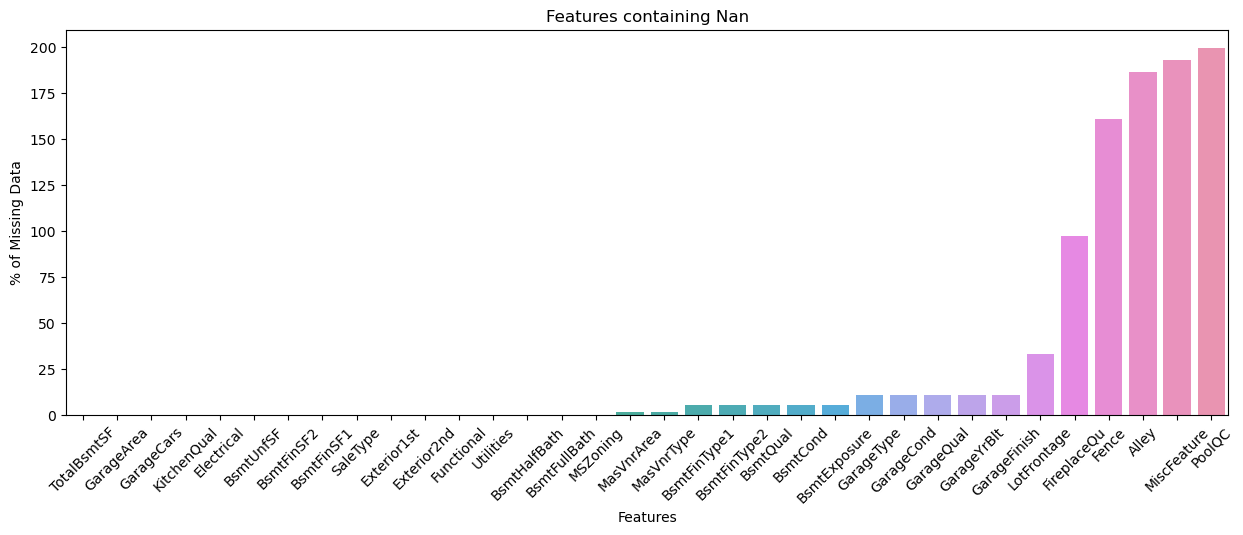

In [11]:
plt.figure(figsize = (15,5))
sns.barplot(x = nan['feat'], y = nan['Perc(%)'])
plt.xticks(rotation=45)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

mising values mostly comes from non exsistent feature of the hous like the case of pool as in the data discribtion  

# filling  Missing Values and Feature Engineering

In [12]:
# Assuming Neighborhood and MSZoning are related.
lookup = (
    stacked_DF.loc[stacked_DF["Train"] == 1]
    .groupby(by="Neighborhood")["MSZoning"]
    .agg(pd.Series.mode)
)
stacked_DF["MSZoning"] = stacked_DF["MSZoning"].fillna(
    stacked_DF["Neighborhood"].map(lookup)
)

# Assuming KitchenQual and OverallQual are related.
lookup = (
    stacked_DF.loc[stacked_DF["Train"] == 1]
    .groupby(by="OverallQual")["KitchenQual"]
    .agg(pd.Series.mode)
)
stacked_DF["KitchenQual"] = stacked_DF["KitchenQual"].fillna(
    stacked_DF["OverallQual"].map(lookup)
)

# For these features I replace nan with a string indicator: "missing"
cols_na_to_missing = {
    "Alley",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFullBath",
    "BsmtQual",
    "Fence",
    "FireplaceQu",
    "GarageCond",
    "GarageFinish",
    "GarageQual",
    "GarageType",
    "MasVnrType",
    "MiscFeature",
    "PoolQC",
    "BsmtFinType2",
}

# For these features I replace nan with the integer 0
cols_na_to_zero = {
    # 'BsmtUnfSF',
    "GarageArea",
    "GarageCars",
    "TotalBsmtSF",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtFullBath",
    "BsmtHalfBath",
    "GarageYrBlt",
}

# For these features I replace nan with the mode of the feature the record is missing.
cols_na_to_mode = {
    "Functional",
    "Electrical",
    "Utilities",
    "Exterior1st",
    "Exterior2nd",
    "SaleType",
}

for col in cols_na_to_missing:
    stacked_DF[col] = stacked_DF[col].astype(object).fillna("Missing")

for col in cols_na_to_zero:
    stacked_DF[col] = stacked_DF[col].astype(object).fillna(0)

for col in cols_na_to_mode:
    stacked_DF[col] = (
        stacked_DF[col]
        .astype(object)
        .fillna(stacked_DF.loc[stacked_DF["Train"] == 1, col].mode()[0])
    )

# Imputing remaining missing values with the help of iterative imputer.
num_features = stacked_DF.drop(columns=["Train"]).select_dtypes("number").columns
imputer = IterativeImputer(
    RandomForestRegressor(max_depth=8),
    n_nearest_features=10,
    max_iter=10,
    random_state=random_state,
)
stacked_DF.loc[stacked_DF["Train"] == 1, num_features] = imputer.fit_transform(
    stacked_DF.loc[stacked_DF["Train"] == 1, num_features].values
)
stacked_DF.loc[stacked_DF["Train"] == 0, num_features] = imputer.transform(
    stacked_DF.loc[stacked_DF["Train"] == 0, num_features].values
)


In [13]:
stacked_DF["WarmSeason"] = np.where(
    stacked_DF["MoSold"].isin([10, 11, 12, 1, 2, 3]), 0, 1
)
stacked_DF["SqFtPerRoom"] = stacked_DF["GrLivArea"] / (
    stacked_DF["TotRmsAbvGrd"]
    + stacked_DF["FullBath"]
    + stacked_DF["HalfBath"]
    + stacked_DF["KitchenAbvGr"]
)

# Converting MSSubClass to categorical
stacked_DF["MSSubClass"] = stacked_DF["MSSubClass"].astype(str)


# Below I establish ranking among categories within a handful of features,
# Ranking is based on the median SalePrice they show for each category.
cateogies_to_rank = [
    "BsmtQual",
    "ExterQual",
    "ExterCond",
    "Exterior1st",
    "FireplaceQu",
    "GarageCond",
    "GarageQual",
    "Heating",
    "Fence",
    "HeatingQC",
    "OverallQual",
    "OverallCond",
    "HouseStyle",
    "KitchenQual",
    "LotShape",
    "BsmtCond",
    "MSSubClass",
    "Neighborhood",
    "SaleCondition",
    "SaleType",
    "MasVnrType",
    "ExterQual",
]

for col in cateogies_to_rank:
    rank = np.array(
        range(0, len(stacked_DF.loc[stacked_DF["Train"] == 1, col].unique()))
    )
    field_val = (
        stacked_DF.loc[stacked_DF["Train"] == 1]
        .groupby(by=col)["SalePrice"]
        .median()
        .sort_values()
        .index
    )
    rankval_mapping = dict(zip(field_val, rank))
    stacked_DF[col + "_ranking"] = stacked_DF[col].map(
        rankval_mapping, na_action="ignore"
    )

# There is an MSSubClass category in test set but not in train. This creates an nan record during ranking.
# I impute that nan record with the mode of the field (based on the train set)
stacked_DF.loc[stacked_DF["MSSubClass_ranking"].isna(), "MSSubClass_ranking"] = 10


# I combine underrepresented categories under one umbrella and/or with another category in the same field
ext2_map = {"AsphShn": "Oth1", "CBlock": "Oth1", "CmentBd": "Oth2", "Other": "Oth2"}
roofmatl_map = {
    "Roll": "Oth1",
    "ClyTile": "Oth1",
    "Metal": "Oth1",
    "CompShg": "Oth1",
    "Membran": "Oth2",
    "WdShake": "Oth2",
}

cond2_map = {"PosA": "Pos", "PosN": "Pos", "RRAe": "Norm", "RRAn": "Norm"}


stacked_DF["Exterior2nd"] = (
    stacked_DF["Exterior2nd"].map(ext2_map).fillna(stacked_DF["Exterior2nd"])
)
stacked_DF["RoofMatl"] = (
    stacked_DF["RoofMatl"].map(roofmatl_map).fillna(stacked_DF["RoofMatl"])
)
stacked_DF["Condition2"] = (
    stacked_DF["Condition2"].map(cond2_map).fillna(stacked_DF["Condition2"])
)

# adding new features to the data 
stacked_DF["QualCond"] = (
    stacked_DF["OverallQual_ranking"] * stacked_DF["OverallCond_ranking"]
)
stacked_DF["HighQualSF"] = stacked_DF["1stFlrSF"] + stacked_DF["2ndFlrSF"]
stacked_DF["HoodNExtCond"] = (
    stacked_DF["Neighborhood_ranking"] * stacked_DF["ExterCond_ranking"]
)
stacked_DF["HoodNPrivacy"] = (
    stacked_DF["Neighborhood_ranking"] * stacked_DF["Fence_ranking"]
)
stacked_DF["AreaOverallQualCond"] = (
    stacked_DF["HighQualSF"]
    * stacked_DF["OverallQual_ranking"]
    * stacked_DF["OverallCond_ranking"]
)
stacked_DF["KitchenQCHighQualSF"] = (
    stacked_DF["HighQualSF"] * stacked_DF["KitchenQual_ranking"]
)
stacked_DF["HoodNOverallQual"] = (
    stacked_DF["Neighborhood_ranking"] * stacked_DF["OverallQual_ranking"]
)
stacked_DF["HoodNMasVnrType"] = (
    stacked_DF["Neighborhood_ranking"] * stacked_DF["MasVnrType_ranking"]
)
stacked_DF["HoodNKitchenQual"] = (
    stacked_DF["Neighborhood_ranking"] * stacked_DF["KitchenQual_ranking"]
)
stacked_DF["HoodNCond1"] = stacked_DF["Neighborhood_ranking"] * stacked_DF["Condition1"]
stacked_DF["HoodNCond2"] = stacked_DF["Neighborhood_ranking"] * stacked_DF["Condition2"]
stacked_DF["HoodNPorch"] = stacked_DF["Neighborhood_ranking"] * (
    stacked_DF["3SsnPorch"] + stacked_DF["EnclosedPorch"] + stacked_DF["OpenPorchSF"]
)

stacked_DF["Age_YrBuilt"] = stacked_DF["YrSold"] - stacked_DF["YearBuilt"]
stacked_DF["Age_YrRemod"] = stacked_DF["YrSold"] - stacked_DF["YearRemodAdd"]
stacked_DF["Age_Garage"] = stacked_DF["YrSold"] - stacked_DF["GarageYrBlt"]
stacked_DF["Remodeled"] = stacked_DF["YearBuilt"] != stacked_DF["YearRemodAdd"]
stacked_DF["Age_YrBuilt"] = stacked_DF["Age_YrBuilt"].apply(lambda x: 0 if x < 0 else x)
stacked_DF["Age_YrRemod"] = stacked_DF["Age_YrRemod"].apply(lambda x: 0 if x < 0 else x)
stacked_DF["Age_Garage"] = stacked_DF["Age_Garage"].apply(lambda x: 0 if x < 0 else x)

sqft_price_table = (
    stacked_DF.loc[stacked_DF["Train"] == 1]
    .groupby(by="Neighborhood")["SalePrice", "GrLivArea"]
    .agg(pd.Series.sum)
)
sqft_price_table["AvgPricePerSqFt"] = (
    sqft_price_table["SalePrice"] / sqft_price_table["GrLivArea"]
)
sqft_price_table.drop(columns=["SalePrice", "GrLivArea"], inplace=True)
stacked_DF["AvgPricePerSqFtPerHood"] = stacked_DF["Neighborhood"].map(
    sqft_price_table.to_dict()["AvgPricePerSqFt"]
)

# Dropping a handful of features as there are other variables that are perfectly correlated to these
# I did trial and error here based on the impact of removing features on RMSE.
stacked_DF.drop(columns=["GarageYrBlt", "Utilities"], inplace=True)

# Would like to visualize some of the newly established features to see their relationship with target.
# Hoping to see some correlation
cols_to_viz = [
    "HighQualSF",
    "KitchenQCHighQualSF",
    "AreaOverallQualCond",
    "HoodNOverallQual",
    "HoodNMasVnrType",
    "HoodNKitchenQual",
]


# Correlation Heatmap


In [14]:
# creat collearation heat map where user can interact to get the value 
output_notebook()

df_to_viz = stacked_DF[stacked_DF["Train"] == 1].drop(columns="Train")

xcorr = abs(df_to_viz.corr())
xcorr.index.name = "Feature1"
xcorr.columns.name = "Feature2"

df = pd.DataFrame(xcorr.stack(), columns=["Corr"]).reset_index()

source = ColumnDataSource(df)

colors = [
    "#75968f",
    "#a5bab7",
    "#c9d9d3",
    "#e2e2e2",
    "#dfccce",
    "#ddb7b1",
    "#cc7878",
    "#933b41",
    "#550b1d",
]

mapper = LinearColorMapper(palette=colors, low=df.Corr.min(), high=df.Corr.max())

f1 = figure(
    plot_width=1000,
    plot_height=1000,
    title="Correlation Heat Map",
    x_range=list(sorted(xcorr.index)),
    y_range=list(reversed(sorted(xcorr.columns))),
    toolbar_location=None,
    tools="hover",
    x_axis_location="above",
)

f1.rect(
    x="Feature2",
    y="Feature1",
    width=1,
    height=1,
    source=source,
    line_color=None,
    fill_color=transform("Corr", mapper),
)

color_bar = ColorBar(
    color_mapper=mapper,
    location=(0, 0),
    ticker=BasicTicker(desired_num_ticks=len(colors)),
    formatter=PrintfTickFormatter(format="%d%%"),
)
f1.add_layout(color_bar, "right")

f1.hover.tooltips = [
    ("Feature1", "@{Feature1}"),
    ("Feature2", "@{Feature2}"),
    ("Corr", "@{Corr}{1.1111}"),
]

f1.axis.axis_line_color = None
f1.axis.major_tick_line_color = None
f1.axis.major_label_text_font_size = "10px"
f1.axis.major_label_standoff = 2
f1.xaxis.major_label_orientation = 1.0

show(f1)


Loading BokehJS ...

In [15]:
stacked_DF[stacked_DF["Train"] == 1].skew()[
    abs(stacked_DF[stacked_DF["Train"] == 1].skew()) > 5
]


LotArea            12.207688
LowQualFinSF        9.011341
3SsnPorch          10.304342
PoolArea           14.828374
MiscVal            24.476794
Heating_ranking    -9.594079
dtype: float64

**Dealing with highly skewed variables**

iditifing skew>5 variable then apply the transformation to deal with it 

In [16]:
highly_skewed_cols = (
    stacked_DF[stacked_DF["Train"] == 1]
    .skew()[abs(stacked_DF[stacked_DF["Train"] == 1].skew()) > 5]
    .index.to_list()
)

ptransformer = PowerTransformer(standardize=False)

stacked_DF.loc[
    stacked_DF["Train"] == 1, highly_skewed_cols
] = ptransformer.fit_transform(
    stacked_DF.loc[stacked_DF["Train"] == 1, highly_skewed_cols]
)
stacked_DF.loc[stacked_DF["Train"] == 0, highly_skewed_cols] = ptransformer.transform(
    stacked_DF.loc[stacked_DF["Train"] == 0, highly_skewed_cols]
)

# Final Preprocessing Steps

apply onehot encoding seperatly for the categorical variables 

In [17]:
# Obtaining a list of categorical, numerical, and boolean - like features.
bool_features = [
    col
    for col in stacked_DF.select_dtypes(include=["number"]).columns
    if np.array_equal(
        np.sort(stacked_DF[col].unique(), axis=0), np.sort([0, 1], axis=0)
    )
]

cat_features = [col for col in stacked_DF.select_dtypes(exclude=["number"]).columns]
num_features = [
    col
    for col in stacked_DF.select_dtypes(include=["number"]).columns
    if col not in (bool_features) and col != "SalePrice"
]

# Holding these two DF 's on the side.
# Will need to concatenate later with the preprocessed(scaled and oh encoded) DF.
bool_features.remove("Train")
X_train_bool = stacked_DF.loc[stacked_DF["Train"] == 1, bool_features]
X_test_bool = stacked_DF.loc[stacked_DF["Train"] == 0, bool_features]

# This list contains features that has the same set of values between train - test
ohe_cols_a = []

# This list contains features that has different set of values between train - test
ohe_cols_b = []

for col in cat_features:
    if set(stacked_DF.loc[stacked_DF["Train"] == 1, col].unique()) != set(
        stacked_DF.loc[stacked_DF["Train"] == 0, col].unique()
    ):
        ohe_cols_b.append(col)

ohe_cols_a = list(set(cat_features) - set(ohe_cols_b))

In [18]:
X_train = stacked_DF.loc[stacked_DF["Train"] == 1].drop(
    labels=["SalePrice", "Train"], axis=1
)
# Applying log transformation to the target variable
y_train = stacked_DF.loc[stacked_DF["Train"] == 1, "SalePrice"].apply(np.log)
X_test = stacked_DF.loc[stacked_DF["Train"] == 0].drop(
    labels=["SalePrice", "Train"], axis=1
)


preprocessor = ColumnTransformer(
    transformers=[
        ("onehota", OneHotEncoder(sparse=False, drop="first"), ohe_cols_a),
        ("onehotb", OneHotEncoder(sparse=False, handle_unknown="ignore"), ohe_cols_b),
        ("scaler", StandardScaler(), num_features),
    ],
    remainder="drop",
)


pipeline = Pipeline(
    [("Preprocessor", preprocessor), ("VarThreshold", VarianceThreshold(0.01))]
)

X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# Get the list of one hot encoded columns and combine them
oh_encoded_a = list(
    preprocessor.named_transformers_.onehota.get_feature_names(ohe_cols_a)
)
oh_encoded_b = list(
    preprocessor.named_transformers_.onehotb.get_feature_names(ohe_cols_b)
)
oh_encoded_cols = oh_encoded_a + oh_encoded_b

feature_names = np.array(oh_encoded_cols + num_features, order="K")

# Filtering out the features dropped by variance threshold
feature_names = feature_names[pipeline.named_steps.VarThreshold.get_support()]

# Putting back the column names to help with analysis
X_train_preprocessed = pd.DataFrame(data=X_train_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(
    data=X_test_preprocessed, columns=feature_names, index=X_test_bool.index
)

# Combine the DF's back together
X_train = pd.concat([X_train_bool, X_train_preprocessed], axis=1)
X_test = pd.concat([X_test_bool, X_test_preprocessed], axis=1)


# Feature Importance

using premutation and lasso fewature ranking 

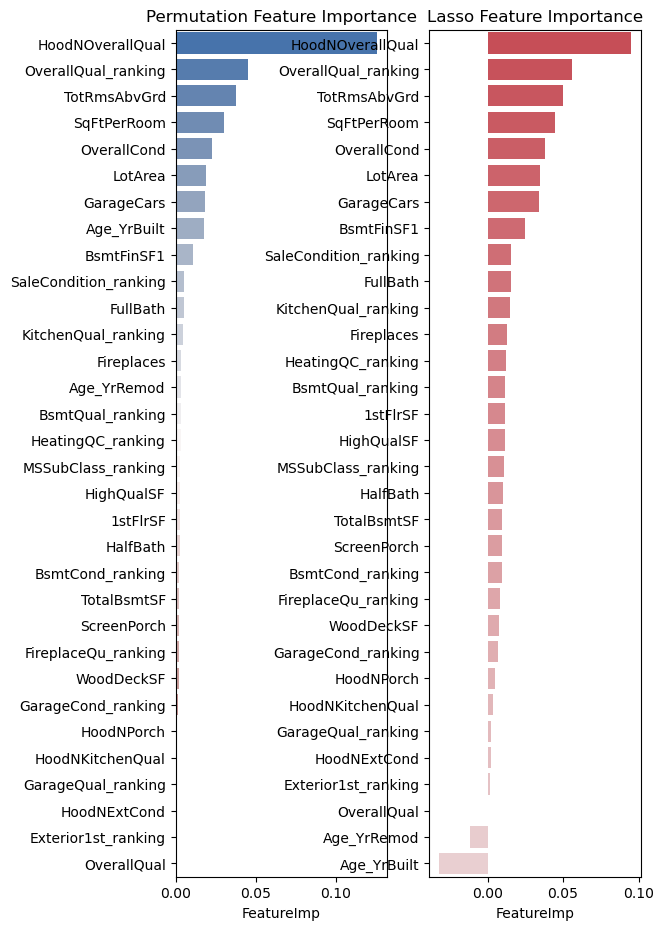

In [19]:
model = Lasso(alpha=0.01)
model.fit(X_train, y_train)


feature_imp = permutation_importance(
    model, X_train, y_train, n_repeats=10, n_jobs=-1, random_state=42, 
)

perm_ft_imp_df = pd.DataFrame(
    data=feature_imp.importances_mean, columns=["FeatureImp"], index=X_train.columns
).sort_values(by="FeatureImp", ascending=False)
model_ft_imp_df = pd.DataFrame(
    data=model.coef_, columns=["FeatureImp"], index=X_train.columns
).sort_values(by="FeatureImp", ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(6, 11))

perm_ft_imp_df_nonzero = perm_ft_imp_df[perm_ft_imp_df["FeatureImp"] != 0]
model_ft_imp_df_nonzero = model_ft_imp_df[model_ft_imp_df["FeatureImp"] != 0]

sns.barplot(
    x=perm_ft_imp_df_nonzero["FeatureImp"],
    y=perm_ft_imp_df_nonzero.index,
    ax=ax[0],
    palette="vlag",
)
sns.barplot(
    x=model_ft_imp_df_nonzero["FeatureImp"],
    y=model_ft_imp_df_nonzero.index,
    ax=ax[1],
    palette=sns.diverging_palette(10, 220, sep=2, n=80),
)

ax[0].set_title("Permutation Feature Importance")
ax[1].set_title("Lasso Feature Importance")

plt.show()

In [20]:
cv = KFold(n_splits=5)


# Hyperparameter optimizing with Optuna

In [21]:
# SVR model hyperparameter optimazation 
def objective(trial):
    _C=trial.suggest_uniform("C", 0.1, 0.5)
    _epsilon=trial.suggest_uniform("epsilon", 0.01, 0.1)
    _coef=trial.suggest_uniform("coef0", 0.5, 1)
    svr=SVR(cache_size=5000, kernel="poly",C=_C, epsilon=_epsilon, coef0=_coef)
    score = cross_val_score(svr, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error").mean()
    return score

optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

svr_params = study.best_params
svr_best_score = study.best_value
print(f"Best score:{svr_best_score} \nOptimized parameters: {svr_params}")

Best score:-0.11836229708039456 
Optimized parameters: {'C': 0.10047748224837959, 'epsilon': 0.05139096564989978, 'coef0': 0.6137026773786289}


In [22]:
# rigide model hyperparameter optimization 

def objective(trial):

    _alpha = trial.suggest_uniform("alpha", 0.5, 1.0)
    _tol = trial.suggest_uniform("tol", 0.5, 0.9 )

    ridge = Ridge(alpha=_alpha, tol=_tol, random_state=random_state)

    score = cross_val_score(
        ridge, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

ridge_params = study.best_params
ridge_best_score = study.best_value
print(f"Best score:{ridge_best_score} \nOptimized parameters: {ridge_params}")


Best score:-0.13378021440339802 
Optimized parameters: {'alpha': 0.9999496671625308, 'tol': 0.5402674907905368}


In [23]:
# lasso hyper parameter optimization 
def objective(trial):

    _alpha = trial.suggest_uniform("alpha", 0.0001, 0.01)

    lasso = Lasso(alpha=_alpha, random_state=random_state)

    score = cross_val_score(
        lasso, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

lasso_params = study.best_params
lasso_best_score = study.best_value
print(f"Best score:{lasso_best_score} \nOptimized parameters: {lasso_params}")


/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.505e-02, tolerance: 1.891e-02
  model = cd_fast.enet_coordinate_descent(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.127e-02, tolerance: 1.800e-02
  model = cd_fast.enet_coordinate_descent(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Best score:-0.12934445542147457 
Optimized parameters: {'alpha': 0.0006275832575701996}


In [24]:
#random forest hyperparameter optimization 
def objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 12)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 8)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 3, 6)
    _max_features = trial.suggest_int("max_features", 10, 50)

    rf = RandomForestRegressor(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        #ccp_alpha=_ccp_alpha,
        min_samples_leaf=_min_samples_leaf,
        max_features=_max_features,
        n_estimators=_n_estimators,
        n_jobs=-1,
        random_state=random_state,
    )

    score = cross_val_score(
        rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

rf_params = study.best_params
rf_best_score = study.best_value
print(f"Best score:{rf_best_score} \nOptimized parameters: {rf_params}")


Best score:-0.13475155364858007 
Optimized parameters: {'n_estimators': 143, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 38}


In [25]:
#LGBMRegressor hyperprameter optimization 
def objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 5, 20)
    _max_depth = trial.suggest_int("max_depth", 3, 8)
    _learning_rate = trial.suggest_uniform("learning_rate", 0.1, 0.4)
    _n_estimators = trial.suggest_int("n_estimators", 50, 150)
    _min_child_weight = trial.suggest_uniform("min_child_weight", 0.2, 0.6)

    lgbm = LGBMRegressor(
        num_leaves=_num_leaves,
        max_depth=_max_depth,
        learning_rate=_learning_rate,
        n_estimators=_n_estimators,
        min_child_weight=_min_child_weight,
        random_state=random_state,
    )

    score = cross_val_score(
        lgbm, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

lgbm_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best score:{lgbm_best_score} \nOptimized parameters: {lgbm_params}")


Best score:-0.12562902393517028 
Optimized parameters: {'num_leaves': 8, 'max_depth': 6, 'learning_rate': 0.1266411050081934, 'n_estimators': 123, 'min_child_weight': 0.2969716100623521}


In [26]:
#catboost hyper parameter optimization 
def objective(trial):
    _iterations = trial.suggest_int("iterations", 100,150)
    _learning_rate = trial.suggest_uniform("learning_rate", 0.03, 0.1)
    _depth = trial.suggest_int("depth", 2,8)
    _l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 3)
    #_od_type = trial.suggest_categorical("od_type",'Iter')
    #_loss_function = trial.suggest_categorical("loss_function",'RMSE')
    _od_wait = trial.suggest_int("od_wait",100,150)
    

    catboost = CatBoostRegressor(
         iterations=_iterations,
         learning_rate=_learning_rate,
         depth=_depth,
         l2_leaf_reg=_l2_leaf_reg,
         od_type='Iter',
         loss_function ='RMSE' ,
         od_wait = _od_wait ,
        random_state=random_state,
     )

    score = cross_val_score(
        catboost, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

catboost_params = study.best_params
catboost_best_score = study.best_value
print(f"Best score:{catboost_best_score} \nOptimized parameters: {catboost_params}")


0:	learn: 0.3833281	total: 58.6ms	remaining: 6.51s
1:	learn: 0.3650378	total: 60.1ms	remaining: 3.31s
2:	learn: 0.3486929	total: 61.4ms	remaining: 2.23s
3:	learn: 0.3346157	total: 62.6ms	remaining: 1.69s
4:	learn: 0.3200249	total: 63.9ms	remaining: 1.37s
5:	learn: 0.3071999	total: 65.1ms	remaining: 1.15s
6:	learn: 0.2935262	total: 66.5ms	remaining: 997ms
7:	learn: 0.2827248	total: 68.3ms	remaining: 888ms
8:	learn: 0.2720188	total: 69.5ms	remaining: 796ms
9:	learn: 0.2624301	total: 70.8ms	remaining: 723ms
10:	learn: 0.2527871	total: 72.4ms	remaining: 665ms
11:	learn: 0.2441776	total: 74.2ms	remaining: 618ms
12:	learn: 0.2365986	total: 75.7ms	remaining: 576ms
13:	learn: 0.2285091	total: 76.8ms	remaining: 537ms
14:	learn: 0.2215053	total: 78.1ms	remaining: 505ms
15:	learn: 0.2148067	total: 79.3ms	remaining: 476ms
16:	learn: 0.2087314	total: 80.3ms	remaining: 449ms
17:	learn: 0.2030514	total: 81.7ms	remaining: 427ms
18:	learn: 0.1975190	total: 83.3ms	remaining: 408ms
19:	learn: 0.1923798	t

In [27]:
# creating vrabiles as the best param 
rf_params = {"max_depth": 12, "max_features": 47, "n_estimators": 124}


svr_params = {
    "kernel": "poly",
    "C": 0.10295232000728598,
    "epsilon": 0.05450916328631391,
    "coef0": 0.6100348889615704,
}

ridge_params = {
    "alpha": 0.9999648306578118,
    "tol": 0.8743291693774883,
    "solver": "cholesky",
}


lasso_params = {"alpha": 0.000459606954544505, "selection": "random"}


lgbm_params = {
    "num_leaves": 12 , 
    "max_depth": 3 , 
    "learning_rate": 0.12894676885617828 ,
    "n_estimators": 132 ,
    "min_child_weight": 0.2220597450723725 
}

catboost_params = {
    "iterations" : 145 ,
    'learning_rate' : 0.08424746087420647 , 
    'depth' : 5 ,
    "loss_function" :'RMSE',
    'logging_level': 'Silent',
    'od_type' : 'Iter', 
    'od_wait' : 130 , 
    'use_best_model' : False ,
    'l2_leaf_reg':2 
    
}


xgboost_params = {
          'n_estimators': 1562 ,
          'learning_rate': 0.020723805358376233 ,
          'max_depth':4 ,
          'min_child_weight': 2 ,
          'subsample': 0.5881827693707931 ,
          'colsample_bytree' : 0.5337376405992558 ,
          'reg_alpha' : 0.005826820959433549 
         
         }


# Model Comparison

using the best parameter and cross validating them to help how we can blened at the end 

In [28]:
# creating the models witht he best tuning 

svr = SVR(**svr_params)
ridge = Ridge(**ridge_params, random_state=random_state)
lasso = Lasso(**lasso_params, random_state=random_state)
lgbm = LGBMRegressor(**lgbm_params, random_state=random_state)
rf = RandomForestRegressor(**rf_params, random_state=random_state)
catboost = CatBoostRegressor(**catboost_params, random_state=random_state)
xgboost = XGBRegressor(**xgboost_params, random_state=random_state)

stack = StackingCVRegressor(
    regressors=[svr, ridge, lasso, lgbm, rf , catboost],
    meta_regressor=LinearRegression(n_jobs=-1),
    random_state=random_state,
    cv=cv,
    n_jobs=-1,
)



In [30]:
# check the preformance by cross validation score 
svr_scores = cross_val_score(
    svr, X_train, y_train, cv=cv, n_jobs=-1, error_score=-1
)
ridge_scores = cross_val_score(
    ridge, X_train, y_train, cv=cv, n_jobs=-1, error_score=-1
)
lasso_scores = cross_val_score(
    lasso, X_train, y_train, cv=cv, n_jobs=-1, error_score=-1
)
lgbm_scores = cross_val_score(
    lgbm, X_train, y_train, cv=cv, n_jobs=-1, error_score=-1
)
rf_scores = cross_val_score(
    rf, X_train, y_train, cv=cv, n_jobs=-1, error_score=-1
)

catboost_scores = cross_val_score(
    catboost, X_train, y_train, cv=cv, n_jobs=-1, error_score=-1
)

xgboost_scores = cross_val_score(
    xgboost, X_train, y_train, cv=cv, n_jobs=-1, error_score=-1
)

stack_scores = cross_val_score(
    stack, X_train, y_train, cv=cv, n_jobs=-1, error_score=-1
)

scores = [svr_scores, ridge_scores, lasso_scores, lgbm_scores, rf_scores,catboost_scores,stack_scores,xgboost_scores]
models = ["SVR", "RIDGE", "LASSO", "LGBM", "RF", "CATBOOST","STACK","Xgbbost"]
score_medians = [
    round(np.median([mean for mean in modelscore]), 6) for modelscore in scores
]
print(models)
print(score_medians)

/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature

['SVR', 'RIDGE', 'LASSO', 'LGBM', 'RF', 'CATBOOST', 'STACK', 'Xgbbost']
[0.915289, 0.896528, 0.902758, 0.902995, 0.886008, 0.898651, 0.91003, 0.908549]


/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/Users/abdulfattah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Lass

# Final Submission
subntitng the inverse log version of the predection after belnding models 

In [31]:
stack.fit(X_train.values, y_train.values)
svr.fit(X_train.values, y_train.values)
xgboost.fit(X_train.values, y_train.values)
y1 = xgboost.predict(X_test.values)
y1 = np.exp(y1)
y2 = svr.predict(X_test.values)
y2 = np.exp(y2)
y3 = stack.predict(X_test.values)
y3 = np.exp(y3)
predict = 0.6*y3 +0.2*y1+ 0.2*y2
submission = pd.DataFrame({"Id": submission_ID, "SalePrice": predict})
submission.to_csv("lastsubmissinwithXGboost1.csv", index=False)